In [1386]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import datetime

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

In [1387]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [1388]:
DATASET_PATH = './train.csv'
DATASET_TEST = './test.csv'

In [1389]:
df = pd.read_csv(DATASET_PATH, sep=',')
df_test = pd.read_csv(DATASET_TEST, sep=',')

# Уменьшение объема памяти датасета

In [1390]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col]. astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                       
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                       df[col] = df[col].astype(np.float32)
                else:
                       df[col] = df[col].astype(np.float64)

    
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:1f}%'.format(100 * (start_mem - end_mem) / start_mem))
                       
    return df

In [1391]:
reduce_mem_usage(df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.69 MB
Decreased by 54.995600%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.093750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.453125
9996,16265,27,2.0,64.307686,37.038422,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.156250
9997,2795,178,1.0,29.648056,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.906250
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.406250


# Визуализация данных

In [1392]:
matplotlib.rcParams.update({'font.size': 14}) # размер шрифта на всех графиках

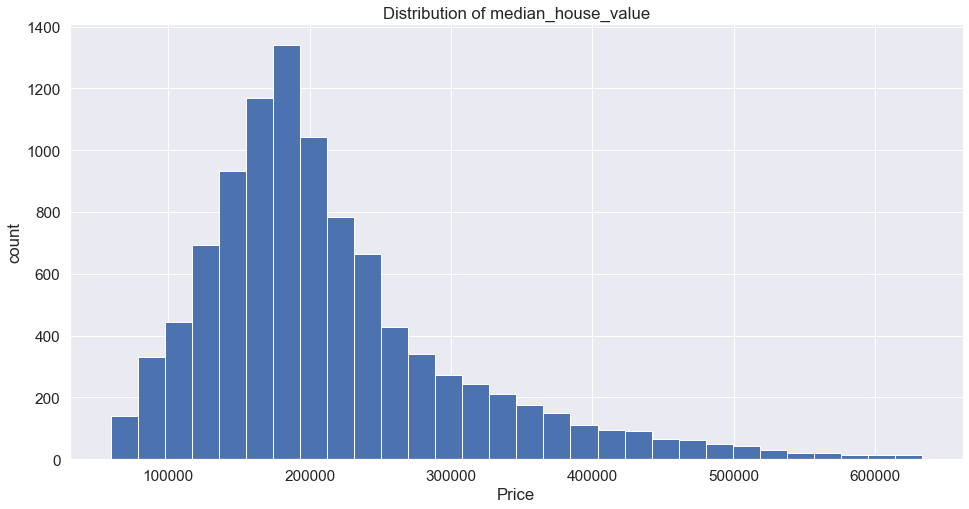

In [1393]:
plt.figure(figsize=(16, 8))

df['Price'].hist(bins=30)
plt.ylabel('count')
plt.xlabel('Price')

plt.title('Distribution of median_house_value')
plt.show()

### Анализ признаков

In [1394]:
df_num_features = df.select_dtypes(include=['float64', 'float32', 'float16'])
df_num_features.drop('Price', axis=1, inplace=True)

In [1395]:
df_num_features.head()

,Rooms,Square,LifeSquare,KitchenSquare,HouseFloor,Ecology_1,Healthcare_1
0,3.0,115.027313,NaN,10.0,10.0,0.075424,NaN
1,1.0,39.832523,23.169222,8.0,8.0,0.118537,1183.0
2,3.0,78.342216,47.671970,10.0,17.0,0.025609,240.0
3,1.0,40.409908,NaN,1.0,22.0,0.007122,NaN
4,2.0,64.285065,38.562515,9.0,16.0,0.282798,NaN


In [1396]:
df['LifeSquare'].fillna(df['LifeSquare'].median(), inplace=True)

In [1397]:
np.quantile(df['Rooms'], q=0.025)

1.0

In [1398]:
df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

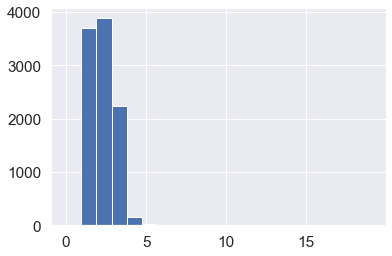

In [1399]:
df['Rooms'].hist(bins=20)
plt.show()

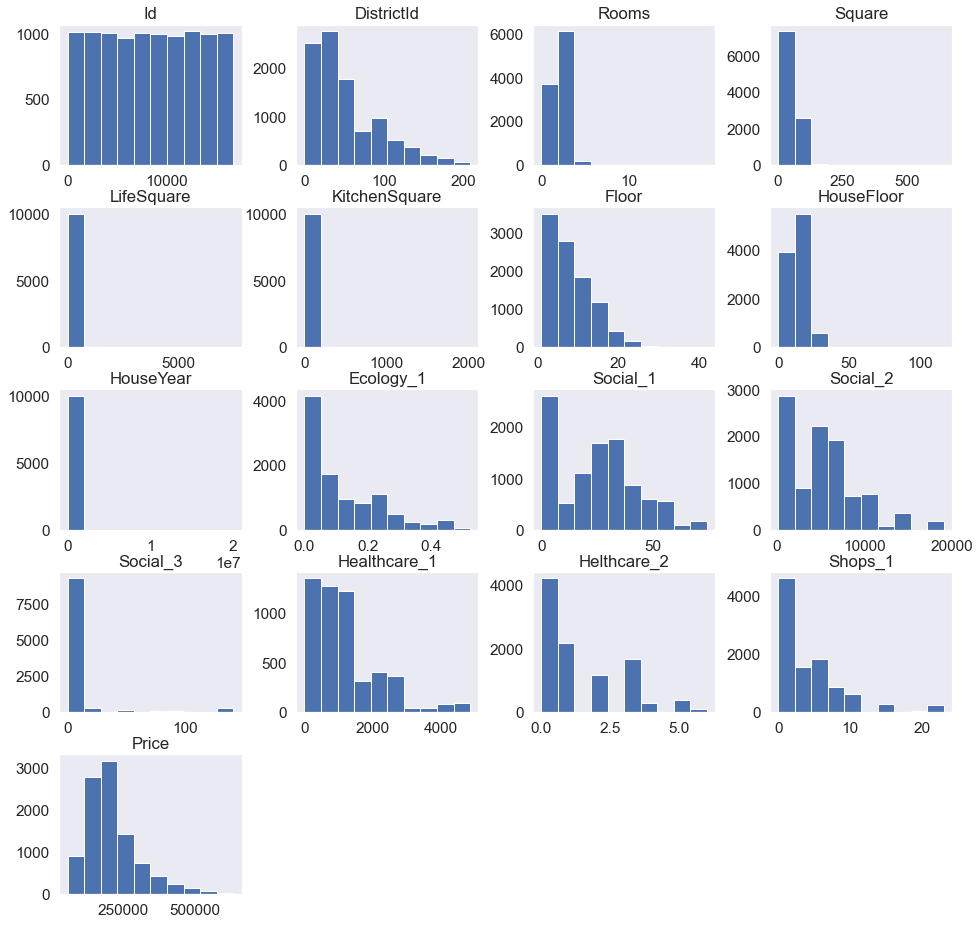

In [1400]:
df.hist(figsize=(16, 16), bins=10, grid=False)
plt.show()

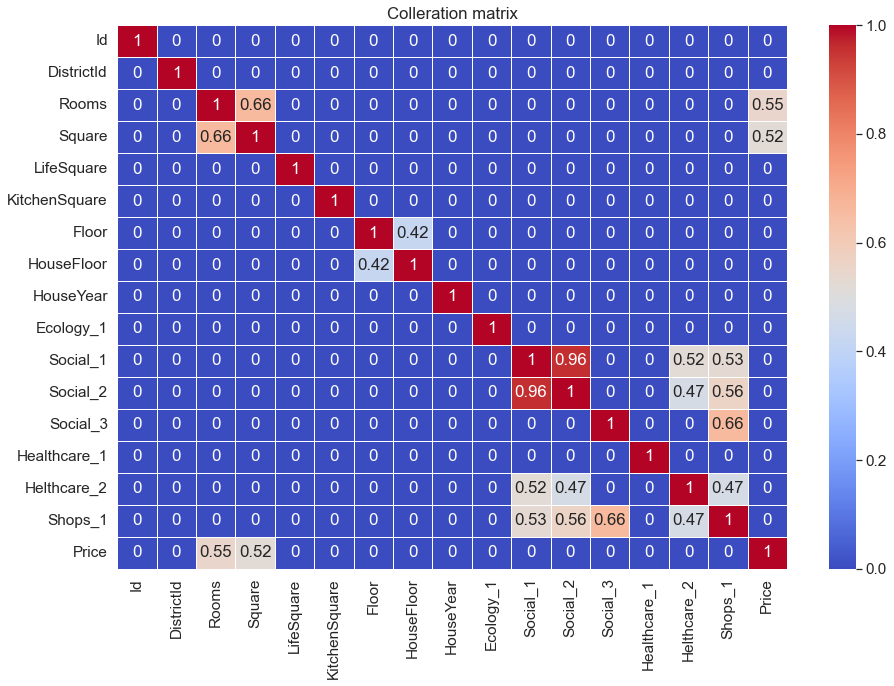

In [1401]:
plt.figure(figsize=(15, 10))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.4] = 0

sns.heatmap(corr_matrix, annot=True, linewidth=.5, cmap='coolwarm')

plt.title('Colleration matrix')
plt.show()

### Нормализация

In [1402]:
# scaler = StandardScaler()

# colnames = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
#        'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
#        'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2',
#        'Shops_1', 'Shops_2']
# colnames

In [1403]:

# X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[colnames]), columns=colnames)
# X_test_scaled = pd.DataFrame(scaler.transform(X_test[colnames]), columns=colnames)

# X_train_scaled.head()

### Анализ групп признаков

In [1404]:
# from sklearn.manifold import TSNE
# from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

# from scipy.spatial.distance import cdist
# from mpl_toolkits.mplot3d.axes3d import Axes3D

In [1405]:
# def reduce_dims(df, dims=2, method='tsne', perplexity=50):
#     assert method in 'tsne', 'Неверно указан метод'
    
#     if method == 'tsne':
#         dim_reducer = TSNE(n_components=dims, learning_rate=250, random_state=42, perplexity=perplexity)
#         components = dim_reducer.fit_transform(df)
#     else:
#         print('Error')
        
#     colnames = ['component_' + str(i) for i in range(1, dims+1)]
#     return dim_reducer, pd.DataFrame(data = components, columns = colnames)

In [1406]:
# def display_components_in_2D_space(components_df, labels=None):
#     components_with_labels_df = pd.concat([components_df, pd.DataFrame(labels)], axis=1)
    
#     figsize = (10, 7)
#     if labels is not None:
#         components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2',
#                                       c=components_with_labels_df.iloc[:, -1], cmap=plt.get_cmap('jet'),
#                                       alpha=0.5, figsize=figsize)
#     else:
#           components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', alpha=0.5, figsize=figsize)
    
#     plt.xlabel('component_1')
#     plt.ylabel('component_2')
#     plt.title('2D mapping of objects')
#     plt.show()

In [1407]:
# def apply_elbow_method(X):
    
#     distortions = []
#     K = range(2, 30)
#     for k in K:
#         kmeanModel = KMeans(n_clusters=k, random_state=33).fit(X)
#         distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    
#     plt.figure(figsize=(10, 8))
#     plt.plot(K, distortions, 'bx-')
#     plt.xlabel('k')
#     plt.ylabel('Distortion')
#     plt.title('The Elbow Method showing the optimal k')
#     plt.show()

In [1408]:
# def display_clusters_distribution(unique_labels, labels_counts):
#     """Визуализация распределения классов по кластерам"""
#     plt.figure(figsize=(8,5))

#     plt.bar(unique, counts)

#     plt.xlabel('Clusters')
#     plt.xticks(unique)
#     plt.ylabel('Count')
#     plt.title('Clusters distribution')
#     plt.show()

In [1409]:
# X = df[['DistrictId', 'Price']]

In [1410]:
# X['LifeSquare_nan'] = 0
# X.loc[df['LifeSquare'].isna(), 'LifeSquare_nan'] = 1
# X['Healthcare_1_nan'] = 0
# X.loc[X['Healthcare_1'].isna(), 'Healthcare_1_nan'] = 1
# X['Healthcare_1'].fillna(self.Healthcare_1_median, inplace=True)
# X['LifeSquare'].fillna((0.61 * df['Square']), inplace=True)
        

In [1411]:
# X

In [1412]:
# dim_reducer2d_tsne, components_2d_tsne = reduce_dims(X, dims=2, method='tsne', perplexity=50)

In [1413]:
# display_components_in_2D_space(components_2d_tsne, y_train)

### Выделение кластеров

In [1414]:
# kmeans = KMeans(n_clusters=20, random_state=42)
# labels_clast = kmeans.fit_predict(X)
# labels_clast = pd.Series(labels_clast, name='clusters')

# labels_clast_test = kmeans.predict(X)
# labels_clast_test = pd.Series(labels_clast, name='clusters')

# unique, counts = np.unique(labels_clast, return_counts=True)
# display_clusters_distribution(unique, counts)

In [1415]:
#display_components_in_2D_space(components_2d_tsne, labels=labels_clast)

In [1416]:
#apply_elbow_method(X)

### DBscan

In [1417]:
# dbscan = DBSCAN(eps=0.1, min_samples=10)
# labels_clast = dbscan.fit_predict(X)
# labels_clast = pd.Series(labels_clast)

# unique, counts = np.unique(labels_clast, return_counts=True)
# display_clusters_distribution(unique, counts)

In [1418]:
#display_components_in_2D_space(components_2d_tsne, labels=labels_clast)

### AgglomerativeClustering

In [1419]:
# from scipy.cluster.hierarchy import dendrogram


# def plot_dendrogram(model, **kwargs):
#     # Create linkage matrix and then plot the dendrogram

#     # create the counts of samples under each node
#     counts = np.zeros(model.children_.shape[0])
#     n_samples = len(model.labels_)
#     for i, merge in enumerate(model.children_):
#         current_count = 0
#         for child_idx in merge:
#             if child_idx < n_samples:
#                 current_count += 1  # leaf node
#             else:
#                 current_count += counts[child_idx - n_samples]
#         counts[i] = current_count

#     linkage_matrix = np.column_stack([model.children_, model.distances_,
#                                       counts]).astype(float)

#     # Plot the corresponding dendrogram
#     dendrogram(linkage_matrix, **kwargs)

In [1420]:
# %%time
# aggl = AgglomerativeClustering(n_clusters=11)
# labels_clast = aggl.fit_predict(X)
# labels_clast = pd.Series(labels_clast)

# unique, counts = np.unique(labels_clast, return_counts=True)
# display_clusters_distribution(unique, counts)

In [1421]:
#display_components_in_2D_space(components_2d_tsne, labels=labels_clast)

In [1422]:
#display_components_in_2D_space(components_2d_tsne, labels=y)

In [1423]:
#components_2d_tsne[['component_1']]

In [1424]:
# df['component_1'] = components_2d_tsne[['component_2']]
# df['component_2'] = components_2d_tsne[['component_1']]

In [1425]:
#df

### Предобработка данных и Feature engineering

In [1465]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.binary_to_numbers = None
        self.housefloor_max_value = None
        self.house_year_min_value = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.kitchen_max_value = None
        self.kitchen_min_value = None
        self.LifeSquare_Square = None
        self.square_max_value = None
        self.square_min_value = None
        self.lifesquare_max_value = None
        self.lifesquare_min_value = None
        
    def fit(self, df):
        
        # Расчет медиан
        
        self.medians = df.median()
        
        # binary_to_numbers
        
        self.binary_to_numbers = {'A': 1, 'B': 0}
        
        # Отношение медианы жилой площади к Общей площади для вычисления замены пропусков
        
        self.LifeSquare_Square = (self.medians['LifeSquare'] / self.medians['Square'])
        
        # Максимальные и минимальные значения признаков
        
        self.square_max_value = 600
        self.square_min_value = 10
        
        
        self.lifesquare_max_value = np.quantile(df['LifeSquare'], q=.975)
        self.lifesquare_min_value = 5
        
        self.housefloor_max_value = 90
        self.house_year_min_value = datetime.now().year - 100
        
        self.kitchen_max_value = np.quantile(df['KitchenSquare'], q=.975)
        self.kitchen_min_value = 3
        
        
    def transform(self, df):
        """Трансформация данных"""
        
    # 1. Пропуски
    
        df['LifeSquare_nan'] = 0
        df.loc[df['LifeSquare'].isna(), 'LifeSquare_nan'] = 1
        df['LifeSquare'].fillna((self.LifeSquare_Square * df['Square']), inplace=True)
        
        df['Healthcare_1_nan'] = 0
        df.loc[df['Healthcare_1'].isna(), 'Healthcare_1_nan'] = 1
        df['Healthcare_1'].fillna(self.medians['Healthcare_1'], inplace=True)
        
    # 2. Исключение ненужных столбцов
    
        df['Id'] = df['Id'].astype('str')
        
        
    # 3. Выбросы (outliers)

        
        # Rooms
        df['Rooms_outlier'] = 0
        df.loc[(df['Rooms'] == 0) | (df['Rooms'] > 5), 'Rooms_outlier'] = 1
        df.loc[(df['Rooms'] == 0), 'Rooms'] = 1
        df.loc[(df['Rooms'] > 5), 'Rooms'] = 5
            
        # Square
        
        df['Square_outlier'] = 0
        df.loc[(df['Square'] > self.square_max_value) | (df['Square'] <= self.square_min_value), 'Square_outlier'] = 1
        df.loc[(df['Square'] > self.square_max_value), 'Square'] = self.square_max_value
        df.loc[(df['Square'] <= self.square_min_value), 'Square'] = self.square_min_value
        
        df['Square'].fillna(self.medians['Square'], inplace=True)

        # KitchenSquare
        condition = (df['KitchenSquare'] > self.kitchen_max_value) | (df['KitchenSquare'] < self.kitchen_min_value)
        df['KitchenSquare_outlier'] = 0
        df.loc[condition, 'KitchenSquare_outlier'] = 1
        df.loc[(df['KitchenSquare'] < self.kitchen_min_value), 'KitchenSquare'] = self.kitchen_min_value
        df.loc[(df['KitchenSquare'] > self.kitchen_max_value), 'KitchenSquare'] = self.medians['KitchenSquare']
        
        df['KitchenSquare'].fillna(self.medians['KitchenSquare'], inplace=True)

        # LifeSquare
        condition = (df['LifeSquare'] < self.lifesquare_min_value) |\
            (df['LifeSquare'] >= (df['Square'] - df['KitchenSquare'])) |\
            (df['LifeSquare'] > self.lifesquare_max_value)
        df['LifeSquare_outlier'] = 0
        df.loc[condition, 'LifeSquare_outlier'] = 1
        df.loc[condition, 'LifeSquare'] = self.LifeSquare_Square * df['Square'] - df['KitchenSquare']
        
        df['LifeSquare'].fillna(self.LifeSquare_Square * df['Square'], inplace=True)

        # HouseFloor
        condition = (df['HouseFloor'] < 1) | (df['HouseFloor'] > self.housefloor_max_value)
        df['HouseFloor_outlier'] = 0
        df.loc[condition, 'HouseFloor_outlier'] = 1
        df.loc[df['HouseFloor'] < 1, 'HouseFloor'] = 1
        df.loc[df['HouseFloor'] > self.housefloor_max_value, 'HouseFloor'] = self.medians['HouseFloor']
        
        df['HouseFloor'].fillna(self.medians['HouseFloor'], inplace=True)

        # Floor
        df['Floor_outlier'] = 0
        df.loc[(df['HouseFloor'] < df['Floor']) | (df['Floor'] < 1), 'Floor_outlier'] = 1
        df.loc[(df['HouseFloor'] < df['Floor']), 'Floor']  = df['HouseFloor']
        df.loc[(df['Floor'] < 1), 'Floor'] = 0
        
        df['Floor'].fillna(self.medians['Floor'], inplace=True)
        
        # HouseYear
        current_year = datetime.now().year
        
        df['HouseYear_outlier'] = 0
        df.loc[(df['HouseYear'] > current_year) | (df['HouseYear'] < self.house_year_min_value), 'HouseYear_outlier'] = 1
        df.loc[(df['HouseYear'] > current_year), 'HouseYear'] = current_year
        df.loc[(df['HouseYear'] < self.house_year_min_value), 'HouseYear'] = self.house_year_min_value
        
        df['HouseYear'].fillna(self.medians['HouseYear'], inplace=True)
        
        
#         # Social_1
#         #social_1_max_value = np.quantile(df['Social_1'], q=0.975)
#         social_1_min_value = 1
#         condition = (df['Social_1'] < social_1_min_value) #| (df['Social_1'] > social_1_max_value) 
#         df['Social_1_outlier'] = 0
#         df.loc[condition, 'Social_1_outlier'] = 1
#         df.loc[condition, 'Social_1'] = self.Social_1_median
        
#         # Social_2
#         social_2_max_value = np.quantile(df['Social_2'], q=0.975)
#         social_2_min_value = np.quantile(df['Social_2'], q=0.025)
#         condition = (df['Social_2'] > social_2_max_value) | (df['Social_2'] < social_2_min_value)
#         df['Social_2_outlier'] = 0
#         df.loc[condition, 'Social_2_outlier'] = 1
#         df.loc[condition, 'Social_2'] = self.Social_2_median

#         # Social_3
#         social_3_max_value = 20
#         social_3_min_value = 0
#         condition = (df['Social_3'] > social_3_max_value) | (df['Social_3'] < social_3_min_value)
#         df['Social_3_outlier'] = 0
#         df.loc[condition, 'Social_3_outlier'] = 1
#         df.loc[condition, 'Social_3'] = self.Social_3_median

        
    # 4. Изменение типа
        
         # Ecology_2
        df['Ecology_2'] = df['Ecology_2'].replace(self.binary_to_numbers)   
        
        # Shops_2
        df['Shops_2'] = df['Shops_2'].replace(self.binary_to_numbers)

        # Ecology_3
        df['Ecology_3'] = df['Ecology_3'].replace(self.binary_to_numbers)
        
    # 5. Новые фичи (features)
            
        #house_age
        current_year = datetime.now().year
        df['house_age'] = current_year - X['HouseYear']
    
        ### СХЛОПНУТь МЕТОДОМ PCA !!!!!!!!!!!!!!!
        # Слияние Social_1 и Social_2
        #df['Social_1_2'] = (df['Social_2'] - self.Social_2_mean)/ df['Social_2'].value_counts().sum() + (df['Social_1'] - self.Social_1_mean)/ df['Social_1'].value_counts().sum()
        #df.drop(['Social_1', 'Social_2'], axis=1, inplace=True)

        return df
             

In [1466]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        
    def fit(self, X, y=None):
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
#         if y is not None:
#             df['Price'] = y.values
            
#             self.med_price_by_district = df.groupby(['Square', 'Rooms'], as_index=False).agg({'Price':'median'})\
#                                             .rename(columns={'Price':'MedPriceByDistrict'})
            
#             self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
#         if y is not None:
#             df['Price'] = y.values
            
#             df = self.floor_to_cat(df)
#             df = self.age_to_cat(df)
#             self.med_price_by_floor_year = df.groupby(['age_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
#                                             rename(columns={'Price':'MedPriceByFloorYear'})
#             self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()


        
    def transform(self, X):
        
        # Категоризация применение
        X = self.age_to_cat(X)
        X = self.floor_to_cat(X)
#         # Target encoding
#         if self.med_price_by_district is not None:
#             X = X.merge(self.med_price_by_district, on=['Square', 'Rooms'], how='left')
            
#             X['MedPriceByDistrict_nan'] = 0
#             X.loc[X['MedPriceByDistrict'].isna(), 'MedPriceByDistrict_nan'] = 1
#             X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
        

#         if self.med_price_by_floor_year is not None:
#             X = X.merge(self.med_price_by_floor_year, on=['age_cat', 'floor_cat'], how='left')
#             X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)

        # Отношение LifeSquare/Square
        X['LifeSquare/Square'] = (X['LifeSquare'] / X['Square'])
        
        # Отношение Rooms/Square
        X['Square/Rooms'] = (X['Square'] / X['Rooms'])

        # Нежилая площадь
        X['NonresidentialSquare'] = X['Square'] - X['LifeSquare'] - X['KitchenSquare']
        
        
        
        return X
         
    # Категоризация этажности

    def floor_to_cat(self, X):

        X['floor_cat'] = 0

        X.loc[(X['Floor'] == 1), 'floor_cat'] = 1
        X.loc[(X['Floor'] >= 2) & (X['Floor'] < 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] >= 5) & (X['Floor'] < 10), 'floor_cat'] = 3
        X.loc[(X['Floor'] >= 10) & (X['Floor'] < 15), 'floor_cat'] = 4
        X.loc[(X['Floor'] >= 15) & (X['Floor'] < 25), 'floor_cat'] = 5
        X.loc[(X['Floor'] >= 25), 'floor_cat'] = 6

        X['floor_cat'].fillna(-1, inplace=True)

        return X


    def age_to_cat(self, X):

        X['age_cat'] = 0

        X.loc[X['house_age'] <= 5, 'age_cat'] = 1
        X.loc[(X['house_age'] > 5) & (X['house_age'] <= 10), 'age_cat'] = 2
        X.loc[(X['house_age'] > 10) & (X['house_age'] <= 15), 'age_cat'] = 3
        X.loc[(X['house_age'] > 15) & (X['house_age'] <= 25), 'age_cat'] = 4
        X.loc[(X['house_age'] > 25) & (X['house_age'] <= 40), 'age_cat'] = 5
        X.loc[(X['house_age'] > 40) & (X['house_age'] <= 45), 'age_cat'] = 6
        X.loc[(X['house_age'] > 45) & (X['house_age'] <= 55), 'age_cat'] = 7
        X.loc[(X['house_age'] > 55), 'age_cat'] = 8

        return X


### Разделение данных

In [1467]:
X = df.drop(columns='Price')

In [1468]:
y = df['Price']

In [1469]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=100)

In [1470]:
pipe = DataPipeline()
pipe.fit(X_train)

X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)
df_test = pipe.transform(df_test)

X_train.isna().sum().sum(), X_test.isna().sum().sum(), df_test.isna().sum().sum()

(0, 0, 0)

In [1471]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_test = features_gen.transform(X_test)
df_test = features_gen.transform(df_test)

X_train.shape, X_test.shape, df_test.shape

((6700, 34), (3300, 34), (5000, 34))

In [1472]:
pd.set_option('display.max_columns', None)

In [1473]:
X_train.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,Healthcare_1_nan,Rooms_outlier,Square_outlier,KitchenSquare_outlier,LifeSquare_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,house_age,age_cat,floor_cat,LifeSquare/Square,Square/Rooms,NonresidentialSquare
8511,5355,74,1.0,53.865501,30.780174,3.0,1.0,1.0,1977,0.075779,0,0,6,1437,3,900.0,0,2,0,0,1,0,0,1,1,1,1,0,44,6,1,0.571427,53.865501,20.085327
1449,11764,93,3.0,169.117203,32.781261,3.0,3.0,3.0,1977,0.004949,0,0,0,186,0,900.0,0,0,0,0,1,0,0,1,0,0,1,0,44,6,2,0.193838,56.372402,133.335938
2965,15528,66,3.0,79.489578,47.728355,12.0,17.0,17.0,2001,0.111627,0,0,50,12238,8,1970.0,2,3,0,0,0,0,0,0,0,0,0,0,20,4,5,0.600435,26.496527,19.761223
9497,10578,22,2.0,45.578159,28.475996,5.0,3.0,5.0,1962,0.118537,0,0,30,6207,1,1183.0,1,0,0,0,0,0,0,0,0,0,0,0,59,8,2,0.624773,22.789080,12.102163
5488,1490,31,1.0,35.803776,20.454700,6.0,1.0,9.0,1974,0.151346,0,1,32,5889,10,830.0,4,1,0,0,0,0,0,0,0,0,0,0,47,7,1,0.571300,35.803776,9.349075


In [1474]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6700 entries, 8511 to 5640
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Id                     6700 non-null   object 
 1   DistrictId             6700 non-null   int16  
 2   Rooms                  6700 non-null   float32
 3   Square                 6700 non-null   float32
 4   LifeSquare             6700 non-null   float32
 5   KitchenSquare          6700 non-null   float32
 6   Floor                  6700 non-null   float32
 7   HouseFloor             6700 non-null   float32
 8   HouseYear              6700 non-null   int32  
 9   Ecology_1              6700 non-null   float32
 10  Ecology_2              6700 non-null   int64  
 11  Ecology_3              6700 non-null   int64  
 12  Social_1               6700 non-null   int8   
 13  Social_2               6700 non-null   int16  
 14  Social_3               6700 non-null   int16  
 15  H

In [1475]:
feature_names_for_stand = X_train.select_dtypes(include=['float64','float32', 'float16', 'int64', 'int32', 'int16', 'int8']).columns

target_name = 'Price'

In [1476]:
X_train.isna().sum().sum(), X_test.isna().sum().sum()

(0, 0)

### Построение модели

In [1477]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 4)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 4)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [1478]:
X_train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,Healthcare_1_nan,Rooms_outlier,Square_outlier,KitchenSquare_outlier,LifeSquare_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,house_age,age_cat,floor_cat,LifeSquare/Square,Square/Rooms,NonresidentialSquare
8511,5355,74,1.0,53.865501,30.780174,3.0,1.0,1.0,1977,0.075779,0,0,6,1437,3,900.0,0,2,0,0,1,0,0,1,1,1,1,0,44,6,1,0.571427,53.865501,20.085327
1449,11764,93,3.0,169.117203,32.781261,3.0,3.0,3.0,1977,0.004949,0,0,0,186,0,900.0,0,0,0,0,1,0,0,1,0,0,1,0,44,6,2,0.193838,56.372402,133.335938
2965,15528,66,3.0,79.489578,47.728355,12.0,17.0,17.0,2001,0.111627,0,0,50,12238,8,1970.0,2,3,0,0,0,0,0,0,0,0,0,0,20,4,5,0.600435,26.496527,19.761223
9497,10578,22,2.0,45.578159,28.475996,5.0,3.0,5.0,1962,0.118537,0,0,30,6207,1,1183.0,1,0,0,0,0,0,0,0,0,0,0,0,59,8,2,0.624773,22.789080,12.102163
5488,1490,31,1.0,35.803776,20.454700,6.0,1.0,9.0,1974,0.151346,0,1,32,5889,10,830.0,4,1,0,0,0,0,0,0,0,0,0,0,47,7,1,0.571300,35.803776,9.349075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,11821,27,1.0,41.674965,32.781261,3.0,14.0,19.0,1977,0.211401,0,0,9,1892,0,900.0,0,1,0,0,1,0,0,1,0,0,0,0,44,6,4,0.786594,41.674965,5.893703
79,2286,99,2.0,47.304764,28.737215,6.0,9.0,9.0,1972,0.012339,0,0,35,5776,1,2078.0,2,4,0,0,0,0,0,0,0,0,0,0,49,7,3,0.607491,23.652382,12.567549
8039,16726,119,2.0,51.313702,32.964130,6.0,9.0,9.0,1973,0.333892,0,0,30,6564,1,900.0,0,0,0,0,1,0,0,0,0,0,1,0,48,7,3,0.642404,25.656851,12.349571
6936,15625,34,3.0,89.665611,53.231171,3.0,19.0,25.0,2016,0.069753,0,0,53,13670,4,900.0,1,11,0,0,1,0,0,1,1,0,0,0,5,1,5,0.593663,29.888536,33.434441


In [1479]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=5,
                                     min_samples_leaf=5,
                                     random_state=42,  
                                     n_estimators=150)

gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)

Train R2:	0.8858
Test R2:	0.7367


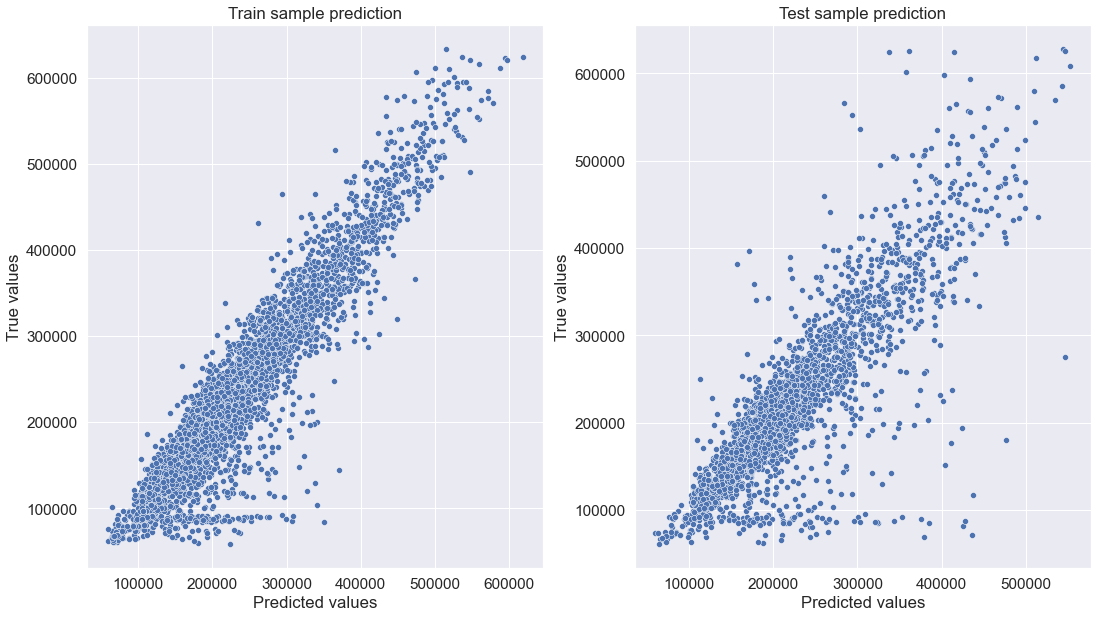

In [1480]:
y_test_preds = gb_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

### Настройка и оценка финальной модели

#### Кросс-валидация

In [1481]:
cv_score = cross_val_score(gb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.73449432, 0.74215911, 0.73918589])

In [1482]:
np.round(cv_score.mean(), 4)

0.7386

In [1458]:
# %%time
# params = {'n_estimators':[150, 200, 250],
#          'max_depth':[4, 5, 6],
#          'min_samples_leaf':[5, 8, 10, 15, 22]}

# gs = GridSearchCV(gb_model, params,
#                   scoring='r2',
#                   cv=KFold(n_splits=5,
#                           random_state=21,
#                           shuffle=True),
#                   n_jobs=-1
#                  )
# gs.fit(X_train, y_train)
                  

Wall time: 3min 53s


GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
             estimator=GradientBoostingRegressor(criterion='mse', max_depth=5,
                                                 min_samples_leaf=5,
                                                 n_estimators=150,
                                                 random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6],
                         'min_samples_leaf': [5, 8, 10, 15, 22],
                         'n_estimators': [150, 200, 250]},
             scoring='r2')

In [1459]:
# gs.best_params_

{'max_depth': 6, 'min_samples_leaf': 5, 'n_estimators': 150}

In [1460]:
# gs.best_score_

0.7444698359407692

#### Обучение и оценка модели

In [1483]:
final_model = GradientBoostingRegressor(criterion='mse',
                                       max_depth=6,
                                       min_samples_leaf=5,
                                       random_state=22,
                                       n_estimators=150)
final_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=6, min_samples_leaf=5,
                          n_estimators=150, random_state=22)

Train R2:	0.9259
Test R2:	0.7362


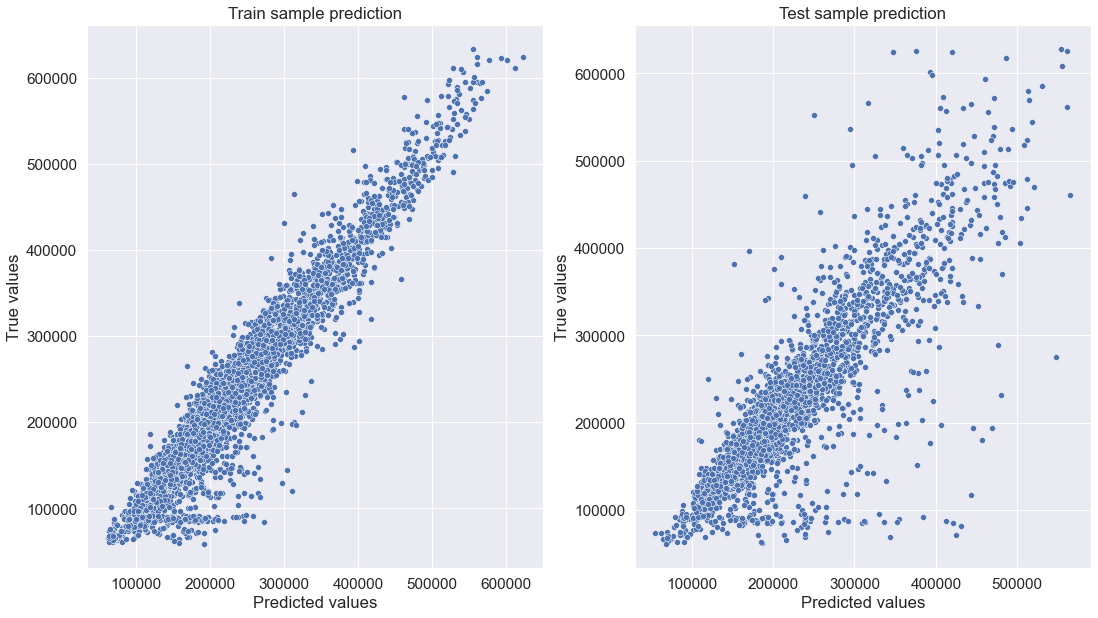

In [1484]:
y_train_preds = final_model.predict(X_train)
y_test_preds = final_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

### Анализ прогнозов

In [1445]:
final_model.feature_importances_

array([4.57957396e-03, 4.98825659e-02, 6.66785108e-02, 3.67198207e-01,
       4.73483179e-02, 1.73653303e-02, 7.81335032e-03, 1.69808022e-02,
       1.39613705e-02, 4.38007121e-02, 2.31716181e-04, 1.08040804e-04,
       1.25998469e-01, 6.40699666e-02, 7.04232495e-02, 2.89599633e-02,
       3.14260734e-03, 9.92454917e-03, 8.37932938e-04, 0.00000000e+00,
       8.84891438e-04, 0.00000000e+00, 7.08829989e-04, 4.30602479e-03,
       4.33651738e-04, 4.61086260e-05, 3.15902146e-04, 2.52158419e-04,
       1.22765856e-02, 4.13064533e-04, 1.04245184e-03, 9.02587271e-03,
       1.19061760e-02, 1.90830462e-02])

In [1446]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

In [1447]:
feature_importances

,feature_name,importance
3,Square,0.367198
12,Social_1,0.125998
14,Social_3,0.070423
2,Rooms,0.066679
13,Social_2,0.064070
1,DistrictId,0.049883
4,LifeSquare,0.047348
9,Ecology_1,0.043801
15,Healthcare_1,0.028960
33,NonresidentialSquare,0.019083


### Сохранение модели

In [1448]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

In [1449]:
with open(MODEL_FILE_PATH, 'rb') as file:
    my_model = pickle.load(file)
    
my_model

GradientBoostingRegressor(criterion='mse', max_depth=5, min_samples_leaf=5,
                          n_estimators=150, random_state=22)

Kaggle

In [1450]:
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,Healthcare_1_nan,Rooms_outlier,Square_outlier,KitchenSquare_outlier,LifeSquare_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,house_age,age_cat,floor_cat,LifeSquare/Square,Square/Rooms,NonresidentialSquare
0,4567,44,1.0,37.0,19.094182,5.0,5.0,9.0,1970,0.036122,0,0,24,4378,0,1036.0,1,1,0,0,0,0,0,0,0,0,0,0,7,2,3,0.516059,37.000000,12.905818
1,5925,62,1.0,42.0,16.339073,10.0,7.0,17.0,2017,0.072158,0,0,2,629,1,900.0,0,0,1,0,1,0,0,0,1,0,0,0,55,7,3,0.389026,42.000000,15.660927
2,960,27,2.0,59.0,37.290908,9.0,19.0,19.0,1977,0.211401,0,0,9,1892,0,900.0,0,1,0,1,1,0,0,0,0,0,0,0,33,5,5,0.632049,29.500000,12.709092
3,3848,23,3.0,50.0,33.893825,6.0,2.0,2.0,1965,0.014073,0,0,2,475,0,900.0,0,0,0,0,1,0,0,0,0,0,0,0,44,6,2,0.677877,16.666667,10.106175
4,746,74,1.0,54.0,33.762336,3.0,8.0,17.0,1977,0.309479,0,0,35,7715,4,990.0,0,6,0,1,0,0,0,1,0,0,0,0,49,7,3,0.625228,54.000000,17.237664


In [1451]:
test_preds = final_model.predict(df_test)

In [1452]:
submission = pd.DataFrame(df_test['Id'])
submission['Price'] = pd.DataFrame(test_preds)
submission

,Id,Price
0,4567,170494.033713
1,5925,109114.114427
2,960,162378.201851
3,3848,144219.841832
4,746,187055.663696
...,...,...
4995,10379,171853.400729
4996,16138,344572.439528
4997,3912,148553.235080
4998,5722,189092.835244


In [1453]:
submission.set_index('Id', inplace=True)

In [1454]:
submission.describe()

,Price
count,5000.000000
mean,216491.186764
std,78364.833748
min,62807.513162
25%,165237.929370
50%,197186.127211
75%,249754.994400
max,574317.446739


In [1455]:
submission.to_csv('./submission.csv', sep=',')